### Cat Classification Using CNN

In [1]:
# # prompt: mount drive

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install tensorflow
# !pip install tensorflow-gpu
# !pip install keras

In [3]:
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
# from keras.optimizers import Adam
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import h5py

# %matplotlib inline
# np.random.seed(1)

# Recommended: use TensorFlow's Keras API for compatibility
from keras.models import Sequential
from keras.layers import Dense, Conv2D, DepthwiseConv2D, Flatten, MaxPooling2D, Activation, LeakyReLU, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import h5py

# For Jupyter notebooks only:
%matplotlib inline

# Set seed for reproducibility
np.random.seed(1)


2025-07-08 12:55:24.434104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751979324.662009      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751979324.730792      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# np.random.seed(1)

## 1 - Overview of the data set

First of all, we'll load the data. After loading, here's a basic overview;

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [5]:
path = "/kaggle/input/image-dataset-of-cat/"

In [6]:
train_dataset = h5py.File(path + 'train.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File(path +'test.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

In [7]:
print(test_dataset.keys())
print(train_dataset.keys())

<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>
<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


In [8]:
classes = np.array(test_dataset["list_classes"][:]) # the list of classes
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [9]:
print(train_set_x_orig.shape)
print(test_set_x_orig.shape)
print(train_set_y_orig.shape)
print(test_set_y_orig.shape)

(209, 64, 64, 3)
(50, 64, 64, 3)
(209,)
(50,)


In [10]:
# train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
# test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
# train_set_y = train_set_y_orig.reshape(-1,1)
# test_set_y = test_set_y_orig.reshape(-1, 1)
train_set_y = train_set_y_orig.reshape(1, -1)
test_set_y = test_set_y_orig.reshape(1, -1)
print(train_set_y.shape)
print(test_set_y.shape)

(1, 209)
(1, 50)


Each line of train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images.

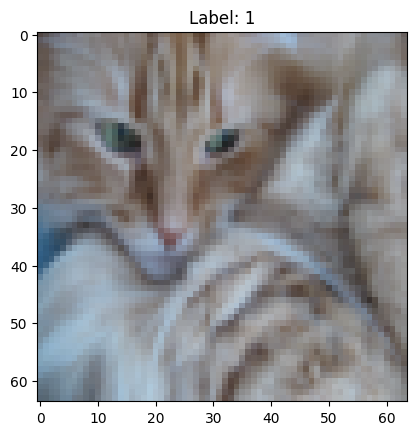

In [11]:
# plt.matshow(train_set_x_orig[0])
# plt.title(f"Label: {train_set_y_orig[0]}")
# plt.show()

#plt.imshow() is the recommended method for displaying images (RGB or grayscale).
plt.imshow(train_set_x_orig[2])
plt.title(f"Label: {train_set_y_orig[2]}")
plt.show()

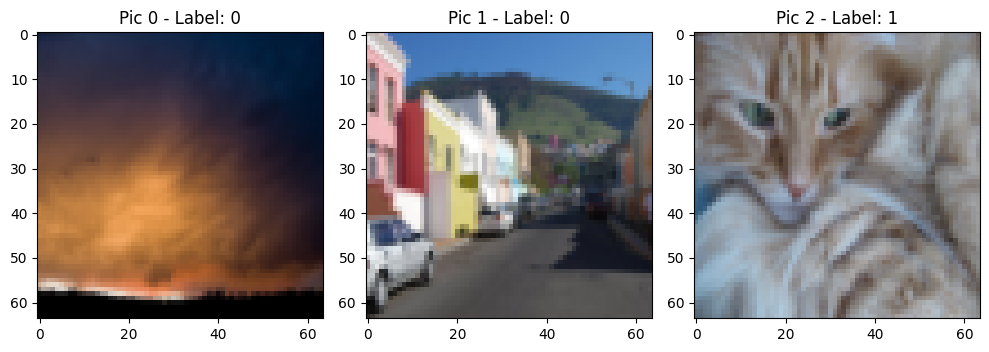

In [12]:
plt.figure(figsize=(10, 4))  # Size of the whole figure

for i, idx in enumerate(range(3)):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, image i+1
    plt.imshow(train_set_x_orig[idx])
    plt.title(f"Pic {idx} - Label: {train_set_y_orig[idx]}")
    # plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
# # Example of a picture
# index = 60
# plt.imshow(train_set_x_orig[index])
# print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

# 2 - Data preprocessing

Following are the steps to preprocess data for a ConvNet.

- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- "Standardize" the data
- Data Augmentation (will discuss later in the course)

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

### 2.1 Dimensions of our data

In [14]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Dataset dimensions:")
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: " + str(train_set_x_orig[0].shape)) #same
print ("Each image is of size: " + str(train_set_x_orig.shape[1:])) #same

Dataset dimensions:
Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
Each image is of size: (64, 64, 3)


In [15]:
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


| Operation         | Input Shape        | Output Shape | When to Use                              |
| ----------------- | ------------------ | ------------ | ---------------------------------------- |
| `.T`              | `(1, m)`           | `(m, 1)`     | When the data is already 2D              |
| `.reshape(-1, 1)` | `(m,)` or `(1, m)` | `(m, 1)`     | Safer and works for both 1D or 2D inputs |


In [16]:
# train_set_y = train_set_y.T
# test_set_y = test_set_y.T
train_set_y = train_set_y.reshape(-1, 1)
test_set_y = test_set_y.reshape(-1, 1)

In [17]:
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209, 1)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50, 1)


| Input Shape        | Operation                                | Output Shape   |
| ------------------ | ---------------------------------------- | -------------- |
 | `train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).shape` | Flatten each image to 1D vector          | `(209, 12288)` |
| `-1`               | Let NumPy automatically compute the size |    `(64 * 64 * 3) = 12288`            |


In [18]:
 # Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)


#Do it above
# # Transpose the train_set_y and test_set_y to have the number of samples as the first dimension
# train_set_y = train_set_y.T
# test_set_y = test_set_y.T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (209, 12288)
train_set_y shape: (209, 1)
test_set_x_flatten shape: (50, 12288)
test_set_y shape: (50, 1)
train_set_x_flatten shape: (209, 12288)
train_set_y shape: (209, 1)
test_set_x_flatten shape: (50, 12288)
test_set_y shape: (50, 1)


### 2.3 Standardizing data

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [19]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [20]:
print ("train_set_x_flatten_Normalizes  shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten_Normalizes  shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten_Normalizes  shape: (209, 12288)
train_set_y shape: (209, 1)
test_set_x_flatten_Normalizes  shape: (50, 12288)
test_set_y shape: (50, 1)


## 3 - Modeling

In [21]:
from numpy.random import seed
seed(1)
# from tensorflow.random import set_seed
# set_seed(2)
import tensorflow as tf
tf.random.set_seed(2)

🔐 Optional for full reproducibility (even better):
If you're doing critical experiments and want exact results across machines:

In [22]:
import os
os.environ['PYTHONHASHSEED'] = '0'

# Optional but useful (if your TensorFlow version supports it)
tf.config.experimental.enable_op_determinism()


### 3.1 Utility function to train & evaluate our models.

In [23]:
# Utility function
def evaluate_this_model(model, epochs, train_set_x_unflattened, train_set_y, batch_size, learning_rate):
    # Use the unflattened training data for the ConvNet model
    np.random.seed(1)

    # Pass train_set_x_unflattened instead of train_set_x
    history = model.fit(train_set_x_unflattened, train_set_y, epochs=epochs, verbose=True, batch_size=batch_size)

    # Similarly, use the unflattened test data for evaluation
    results = model.evaluate(test_set_x_orig, test_set_y) # Assuming test_set_x_orig is available in scope or passed

    plt.plot(np.squeeze(history.history["loss"]))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.title("Model Loss")
    plt.show()

    print("\n\nAccuracy on training set is {}".format(history.history["accuracy"][-1])) # Use 'accuracy' for Keras metrics
    print("\nAccuracy on test set is {}".format(results[1]))

### 3.2 Model Architecture

In [24]:
train_set_x_orig.shape[1:]

(64, 64, 3)

In [25]:
model = Sequential()

# Changed nb_filter to filters, nb_row/nb_col to kernel_size, and border_mode to padding

# 1st Conv Block
model.add(Input(shape=train_set_x_orig.shape[1:]))
# model.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# 2st Conv Block
model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same', use_bias=False))
model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.01))
model.add(LeakyReLU(negative_slope=0.01))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25)) # Drop 25% of neurons

# 3nd Conv Block
model.add(Conv2D(filters=64, kernel_size=(1, 1), padding='same', use_bias=False)) #32 → 64 → 128
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# 4rd Conv Block
model.add(Conv2D(filters=128, kernel_size=(1, 1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Dense Layers
model.add(Flatten())

# If your last Conv2D output is (batch_size, 8, 8, 20)
# → GlobalAveragePooling2D() will give (batch_size, 20) instead of (batch_size, 8*8*20 = 1280) like Flatten does.
# That’s a huge reduction in parameters before the dense layers.
# model.add(GlobalAveragePooling2D())

model.add(Dense(units=128, use_bias=False)) #units are neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))  # Drop 30%

model.add(Dense(units=64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(units=1, activation='sigmoid'))  # Binary classification


I0000 00:00:1751979342.247981      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### 3.3 Compilation

In [26]:
learning_rate = 0.0001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [27]:
# !pip install --upgrade tensorflow

Epoch 1/150


2025-07-08 12:55:44.020541: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
E0000 00:00:1751979348.594636      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:175197

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6371 - loss: 0.7287
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6555 - loss: 0.6210
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6820 - loss: 0.5857
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7427 - loss: 0.5090
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6895 - loss: 0.5251
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7549 - loss: 0.5075
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7501 - loss: 0.4885
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7897 - loss: 0.4475
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8480 - loss: 0.4047
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7988 - loss: 0.4074
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8235 - loss: 0.4048
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7872 - loss: 0.4300
E

2025-07-08 12:56:07.886276: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6825 - loss: 0.8187 


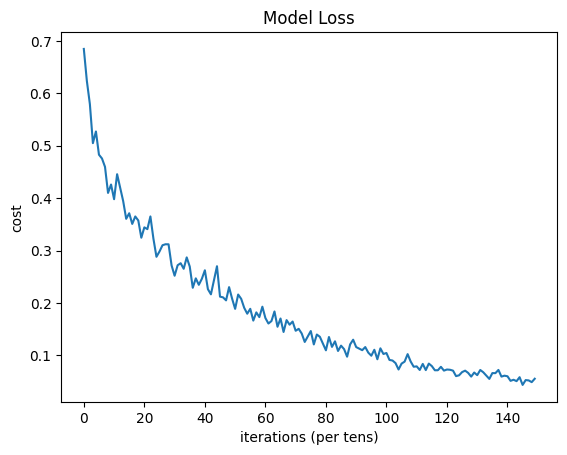



Accuracy on training set is 0.9952152967453003

Accuracy on test set is 0.6800000071525574


In [28]:
evaluate_this_model(model = model,
                    epochs = 150,
                    train_set_x_unflattened = train_set_x_orig,
                    train_set_y = train_set_y,
                    batch_size=32,
                    learning_rate=learning_rate) # Corrected call with unflattened data


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,204,837 (12.23 MB)

 Trainable params: 1,068,001 (4.07 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 2,136,004 (8.15 MB)

In [30]:
y_pred = model.predict(test_set_x_orig)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


In [31]:
y_pred.shape

(50, 1)

In [32]:
y_pred[:3]

array([[0.97578454],
       [0.9431258 ],
       [0.16674016]], dtype=float32)

In [33]:
# # For multi-class classification (e.g., softmax output)
# # y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_pred_labels = (y_pred > 0.9).astype(int).reshape(-1)
true_labels = test_set_y_orig.reshape(-1)

In [34]:
print("predictions Values: ",y_pred_labels[:5])
print("Actual Values: ",true_labels[:5])
print("predictions Shape: ",y_pred_labels.shape)
print("Actual Shape: ",true_labels.shape)

predictions Values:  [1 1 0 0 1]
Actual Values:  [1 1 1 1 1]
predictions Shape:  (50,)
Actual Shape:  (50,)


In [35]:
true_s = (true_labels ==1).sum()
false_s = (true_labels ==0).sum()
print('True / Cat',true_s)
print('False / Non Cat',false_s)

True / Cat 33
False / Non Cat 17


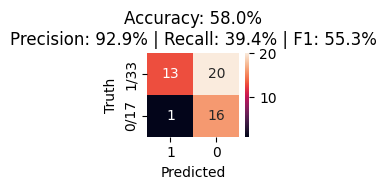

In [36]:
# Example predictions and true labels (ensure both are 1D arrays of 0s and 1s)
y_true = true_labels       # Replace with your actual true labels
y_pred = y_pred_labels     # Replace with your predicted labels

# Confusion Matrix (with label order 1, 0 as requested)
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(2, 2))
sn.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=[1, 0], yticklabels=['1/'+ str(true_s), '0/'+ str(false_s)])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title(f'Accuracy: {accuracy*100:.1f}%\nPrecision: {precision*100:.1f}% | Recall: {recall*100:.1f}% | F1: {f1*100:.1f}%')
plt.tight_layout()
plt.show()
